分析並預測信用卡用戶違約資料
====================
2005年台灣信用卡違約用戶資料分析。由 Kaggle 所提供之資料，[Default Payments of Credit Card Clients in Taiwan from 2005](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset)，其中有30,000筆台灣信用卡用戶的用戶資料以及違約情形，資料格式包含了性別、教育程度、信用卡額度、年齡等基本資料，以及2005年4月到9月付款狀況、信用卡帳務、還款金額等資料。

本研究除了針對用戶的分佈資料進行分析之外，還利用信用卡用戶的付款狀況、信用卡帳務、還款金額等資料建立模型分析並預測用戶是否會違約。

模型是利用機器學習的 KMean Cluster 結合 Linear Probability Model 統計模型完成，先利用 KMean Cluster 將用戶依照信用卡付款狀況進行分類，之後再將分類完的分群進行利用 Linear Probability Model 計算該群體的違約機率，利用此方法可以將原本整體違約機率約22%的全體用戶，分成違約機率 10% 至 78% 共 19 群的群體。最後再依分群完的機率經過設定的機率閥值換算後，準確率可達 81.15% 。與 Kaggle 上其他模型的 82% 相近。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

pd.options.display.max_columns = 35
pd.options.display.max_rows = 100

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
rawdata = pd.read_csv('UCI_Credit_Card.csv', index_col='ID')
print('Shape of Raw Data:', rawdata.shape)
print('一共30,000筆資料，含是否違約合計24個變數')
rawdata.rename(columns={
                        'PAY_0':'PAY_Sept', 'PAY_2':'PAY_Aug', 
                        'PAY_3':'PAY_Jul', 'PAY_4':'PAY_Jun', 
                        'PAY_5':'PAY_May', 'PAY_6':'PAY_Apr',
                        'BILL_AMT1':'BILL_AMT_Sept','BILL_AMT2':'BILL_AMT_Aug',
                        'BILL_AMT3':'BILL_AMT_Jul', 'BILL_AMT4':'BILL_AMT_Jun',
                        'BILL_AMT5':'BILL_AMT_May', 'BILL_AMT6':'BILL_AMT_Apr',
                        'PAY_AMT1':'PAY_AMT_Sept','PAY_AMT2':'PAY_AMT_Aug',
                        'PAY_AMT3':'PAY_AMT_Jul', 'PAY_AMT4':'PAY_AMT_Jun',
                        'PAY_AMT5':'PAY_AMT_May', 'PAY_AMT6':'PAY_AMT_Apr',
                        'default.payment.next.month':'is_default'
                        }, inplace=True)

repay_status = rawdata[['PAY_Sept','PAY_Aug','PAY_Jul','PAY_Jun','PAY_May','PAY_Apr']]

bill_statement = rawdata[['BILL_AMT_Sept','BILL_AMT_Aug','BILL_AMT_Jul',
                          'BILL_AMT_Jun','BILL_AMT_May','BILL_AMT_Apr',]]

prev_payment = rawdata[['PAY_AMT_Sept','PAY_AMT_Aug','PAY_AMT_Jul',
                        'PAY_AMT_Jun','PAY_AMT_May','PAY_AMT_Apr']]

rawdata.head(5)

Shape of Raw Data: (30000, 24)
一共30,000筆資料，含是否違約合計24個變數


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_Sept,PAY_Aug,PAY_Jul,PAY_Jun,PAY_May,PAY_Apr,BILL_AMT_Sept,BILL_AMT_Aug,BILL_AMT_Jul,BILL_AMT_Jun,BILL_AMT_May,BILL_AMT_Apr,PAY_AMT_Sept,PAY_AMT_Aug,PAY_AMT_Jul,PAY_AMT_Jun,PAY_AMT_May,PAY_AMT_Apr,is_default
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### is_default 檢查違約人數及比例

In [3]:
is_default = rawdata['is_default']
show_default = pd.concat([is_default.value_counts(), 
                          is_default.value_counts(normalize=True)],
                          axis=1)
show_default.columns = ['人數', '百分比']
show_default.index = ['正常', '違約']
print('整體違約人數及比例：')
show_default

整體違約人數及比例：


,人數,百分比
正常,23364,0.7788
違約,6636,0.2212


# 1. Demographic Factors 人口因素

### Limit Balance 信用額度

信用額度之敘述統計資料：
count      30000.0
mean      167484.0
std       129748.0
min        10000.0
25%        50000.0
50%       140000.0
75%       240000.0
max      1000000.0
Name: LIMIT_BAL, dtype: float64


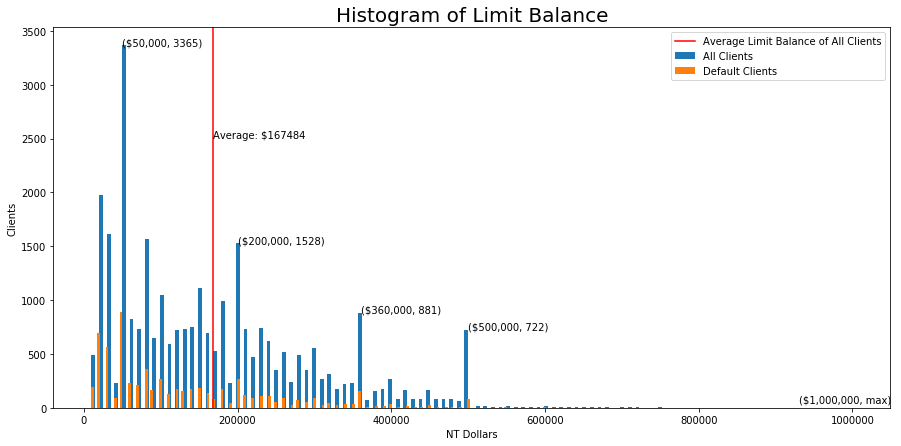

In [4]:
# Limit Balance 信用額度
limit_bal = rawdata.LIMIT_BAL
print('信用額度之敘述統計資料：')
print(limit_bal.describe().round())

%matplotlib inline

fig, ax = plt.subplots(figsize=(15,7))

# 總體信用額度分佈情形
n, bins, patches = plt.hist(limit_bal, bins=200)
ax.text(50000,3365,'($50,000, 3365)')
ax.text(200000,1528,'($200,000, 1528)')
ax.text(360000,881,'($360,000, 881)')
ax.text(500000,722,'($500,000, 722)')
ax.text(930000,50,'($1,000,000, max)')
ax.text(167484,2500,'Average: $167484')

# 違約用戶之信用額度分佈情形
n, bins, patches = plt.hist(limit_bal[is_default==1], bins=200)

# 用紅線畫出平均數
plt.axvline(x=167484.0, color='red')
plt.xlabel

plt.legend(['Average Limit Balance of All Clients',
            'All Clients',
            'Default Clients'])
plt.title('Histogram of Limit Balance', fontsize=20)
plt.ylabel('Clients')
plt.xlabel('NT Dollars')
plt.show()

可以看到一個滿有趣的現象，在
1. (\$50,000, 3365)
2. (\$200,000, 1528)
3. (\$360,000, 881)
4. (\$500,000, 722)

這幾個點的時候比例特別的多，應該是有什麼原因，也許是有些門檻之類的，之後可以好好探討，也許把這幾個點的資料拉出來看，可能倒帳的機率有比較低？因為不會倒帳所以核的特別多？

### Gender 性別資料

In [5]:
gender_map = {1:'Male', 2:'Female'}
gender = rawdata.SEX.map(gender_map)

default_rate_by_gender = gender[is_default==1].value_counts() / \
                         gender.value_counts()
    
gender_stats = pd.concat([gender.value_counts(), 
               gender.value_counts(normalize=True), 
               gender[is_default==1].value_counts(),
               default_rate_by_gender], axis=1)
gender_stats.columns = ['人數', '人數比例', '違約人數', '違約率']
print('性別資料：')
gender_stats

性別資料：


,人數,人數比例,違約人數,違約率
Female,18112,0.603733,3763,0.207763
Male,11888,0.396267,2873,0.241672


可以看到整體資料中男女性別比例大約是，女性60%、男性40%。而男女的違約比例上，男性違約率24.16%高於女性的20.78%。

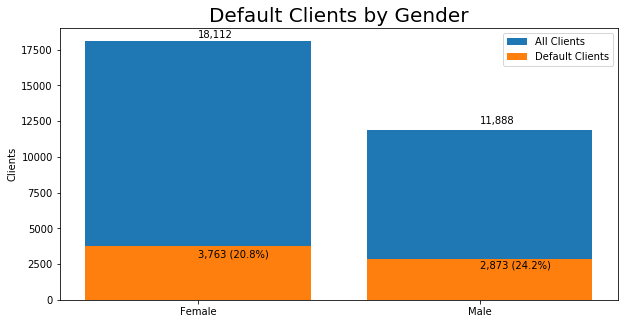

In [6]:
# Gender 繪圖
fig, ax = plt.subplots(figsize=(10,5))

ax.text(0,18300,'18,112')
ax.text(0,3000,'3,763 (20.8%)')
ax.text(1,12300,'11,888')
ax.text(1,2200,'2,873 (24.2%)')

plt.bar(gender.value_counts().index,
        gender.value_counts())

plt.bar(gender[is_default==1].value_counts().index,
        gender[is_default==1].value_counts())

plt.legend(['All Clients',
            'Default Clients'])
plt.title('Default Clients by Gender', fontsize=20)
plt.ylabel('Clients')
plt.show()

### Education 學歷

In [7]:
edu_map = {1:'Graduate school', 2:'University', 3:'High school', 4:'Others',
           5:'Unknown', 6:'Unknown'}
education = rawdata.EDUCATION.map(edu_map)

default_rate_by_education = education[is_default==1].value_counts() / \
                            education.value_counts()
    
education_stats = pd.concat([education.value_counts(), 
                             education.value_counts(normalize=True), 
                             education[is_default==1].value_counts(), 
                             default_rate_by_education], axis=1)
education_stats.columns = ['人數', '人數比例', '違約人數', '違約率']
print('學歷資料：')
education_stats

學歷資料：


,人數,人數比例,違約人數,違約率
University,14030,0.467885,3330,0.237349
Graduate school,10585,0.352998,2036,0.192348
High school,4917,0.163977,1237,0.251576
Unknown,331,0.011038,26,0.078550
Others,123,0.004102,7,0.056911


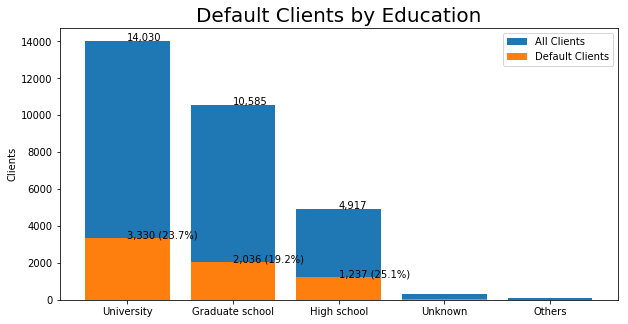

In [8]:
fig, ax = plt.subplots(figsize=(10,5))


ax.text(0,14030,'14,030')
ax.text(0,3330,'3,330 (23.7%)')
ax.text(1,10585,'10,585')
ax.text(1,2036,'2,036 (19.2%)')
ax.text(2,4917,'4,917')
ax.text(2,1237,'1,237 (25.1%)')

plt.bar(education.value_counts().index,
        education.value_counts())

plt.bar(education[is_default==1].value_counts().index,
        education[is_default==1].value_counts())

plt.legend(['All Clients',
            'Default Clients'])
plt.title('Default Clients by Education', fontsize=20)
plt.ylabel('Clients')
plt.show()

### Marriage 婚姻狀況

In [9]:
marri_map = {1:'Married', 2:'Single', 3:'Others'}
marriage = rawdata.MARRIAGE.map(marri_map)

default_rate_by_marriage = marriage[is_default==1].value_counts() / \
                            marriage.value_counts()
    
marriage_stats = pd.concat([marriage.value_counts(), 
                             marriage.value_counts(normalize=True), 
                             marriage[is_default==1].value_counts(), 
                             default_rate_by_marriage], axis=1)
marriage_stats.columns = ['人數', '人數比例', '違約人數', '違約率']
print('婚姻狀況資料：')
marriage_stats

婚姻狀況資料：


,人數,人數比例,違約人數,違約率
Single,15964,0.533093,3341,0.209283
Married,13659,0.456121,3206,0.234717
Others,323,0.010786,84,0.260062


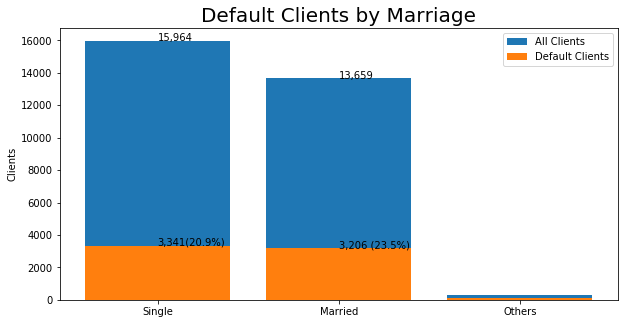

In [10]:
fig, ax = plt.subplots(figsize=(10,5))


ax.text(0,15964,'15,964')
ax.text(0,3341,'3,341(20.9%)')
ax.text(1,13659,'13,659')
ax.text(1,3206,'3,206 (23.5%)')

plt.bar(marriage.value_counts().index,
        marriage.value_counts())

plt.bar(marriage[is_default==1].value_counts().index,
        marriage[is_default==1].value_counts())

plt.legend(['All Clients',
            'Default Clients'])
plt.title('Default Clients by Marriage', fontsize=20)
plt.ylabel('Clients')
plt.show()

### Age 年齡

In [11]:
age = rawdata.AGE
age_bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, np.Inf]
age_map = {
            pd.Interval(20.0, 25.0, closed='right'):'20-25',
            pd.Interval(25.0, 30.0, closed='right'):'26-30',
            pd.Interval(30.0, 35.0, closed='right'):'31-35',
            pd.Interval(35.0, 40.0, closed='right'):'36-40',
            pd.Interval(40.0, 45.0, closed='right'):'41-45',
            pd.Interval(45.0, 50.0, closed='right'):'46-50',
            pd.Interval(50.0, 55.0, closed='right'):'51-55',
            pd.Interval(55.0, 60.0, closed='right'):'56-60',
            pd.Interval(60.0, np.Inf, closed='right'):'60-'}

age = age.map(age_map)
age.value_counts()
default_rate_by_age = age[is_default==1].value_counts() / \
                            age.value_counts()
    
age_stats = pd.concat([age.value_counts(), 
                             age.value_counts(normalize=True), 
                             age[is_default==1].value_counts(), 
                             default_rate_by_age], axis=1)
age_stats.columns = ['人數', '人數比例', '違約人數', '違約率']
print('年齡資料：')
age_stats.sort_index()

年齡資料：


,人數,人數比例,違約人數,違約率
20-25,3871,0.129033,1032,0.266598
26-30,7142,0.238067,1439,0.201484
31-35,5796,0.193200,1126,0.194272
36-40,4917,0.163900,1063,0.216189
41-45,3605,0.120167,798,0.221359
46-50,2400,0.080000,601,0.250417
51-55,1425,0.047500,353,0.247719
56-60,572,0.019067,151,0.263986
60-,272,0.009067,73,0.268382


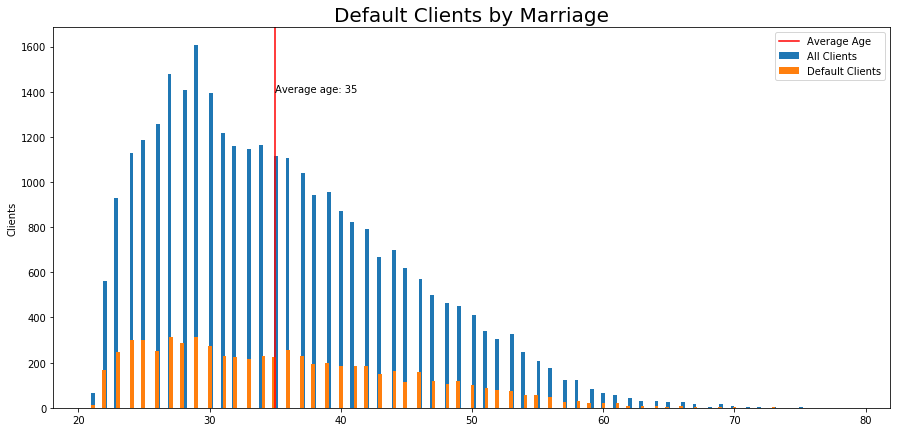

In [12]:
# Age
age = rawdata.AGE
fig, ax = plt.subplots(figsize=(15,7))
ax.text(35,1400,'Average age: 35')
n, bins, patches = plt.hist(age, bins=200)
n, bins, patches = plt.hist(age[is_default==1], bins=200)
# 用紅線畫出平均數
plt.axvline(x=35, color='red')
plt.legend(['Average Age',
            'All Clients',
            'Default Clients'])
plt.title('Default Clients by Marriage', fontsize=20)
plt.ylabel('Clients')
plt.show()

# 2. Bill Statement 信用卡帳務
## 信用卡帳務資料異常

### 信用卡帳務資料異常，全部都為 0 或是為 負值
信用卡帳務應該要為正或是零以上的值，出現負值所代表的意義與原因還需要再探討，可能是因為帳務記錄出錯或是有其他的涵意；而全部為零很可能是該用戶並未使用該信用卡，在沒有資料的情形下很難去預測該用戶是否違約。

In [13]:
# 信用卡帳務資料異常，全部都為 0 或是為 負值
abnormal_bill_record = bill_statement.loc[(bill_statement<=0).all(axis=1)]
print('檢視信用卡帳務資料異常：')
abnormal_bill_record.head(10)

檢視信用卡帳務資料異常：


,BILL_AMT_Sept,BILL_AMT_Aug,BILL_AMT_Jul,BILL_AMT_Jun,BILL_AMT_May,BILL_AMT_Apr
ID,,,,,,
19,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.0,0.0,0.0
110,-103.0,-103.0,-103.0,-103.0,-103.0,-103.0
122,0.0,0.0,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,0.0,0.0,0.0
126,0.0,0.0,0.0,0.0,0.0,0.0
141,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
abnormal_default = is_default[abnormal_bill_record.index]
abnormal_default_show = pd.concat([abnormal_default.value_counts(), 
                        abnormal_default.value_counts(normalize=True)], axis=1)
abnormal_default_show.columns = ['人數', '百分比']
abnormal_default_show.index = ['正常', '違約']
print('帳務資料異常之違約人數及違約率：')
abnormal_default_show

帳務資料異常之違約人數及違約率：


,人數,百分比
正常,619,0.640787
違約,347,0.359213


信用卡帳務資料異常之違約率為35.9%，比先前計算的整體用戶違約率22.12%來得高，但是取樣不同無法確認是統計上的誤差導致，還是確實帳務資料異常之違約率會比較高，需要進行統計檢定才能得知。

### 檢查信用卡帳務資料異常用戶的違約率是否與全體用戶有顯著地不同
這裡使用 Linear Probability Model 來檢查是否顯著，將帳務資料異常用戶標記為1，正常的標記為0的dummy variable，對是否違約進行迴歸，如果該dummy variable有顯著的係數的話，即表示帳務資料異常用戶的違約率與全體用戶不同。

In [15]:
# 建立信用卡帳務資料異常用戶的 dummy variable
rawdata['is_bill_abnormal'] = 0
rawdata.loc[abnormal_bill_record.index, 'is_bill_abnormal'] = 1

# 利用 OLS 檢驗如果帳務異常(帳務記錄,bill statement, 皆為 0 或負數時)，違約比例是
# 否有所不同。這邊將有帳務記錄異常的以 dummy variable 的方式記為 1，否則記為 0 。
model = sm.OLS(rawdata.is_default, 
               sm.add_constant(rawdata.is_bill_abnormal))
result = model.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.004     
Dependent Variable: is_default       AIC:                32269.0754
Date:               2018-04-23 21:03 BIC:                32285.6933
No. Observations:   30000            Log-Likelihood:     -16133.   
Df Model:           1                F-statistic:        110.8     
Df Residuals:       29998            Prob (F-statistic): 7.40e-26  
R-squared:          0.004            Scale:              0.17165   
--------------------------------------------------------------------
                   Coef.   Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const              0.2166    0.0024  89.0858  0.0000  0.2118  0.2214
is_bill_abnormal   0.1426    0.0135  10.5244  0.0000  0.1160  0.1692
-------------------------------------------------------------------
Omnibus:              5428.576      Durbin-Watson:         1.998   
Prob(Omnibus):        0.000         Jarque-Bera (JB):      8998.900
Skew:                 1.338         Prob(JB):              0.000   
Kurtosis:             2.815         Condition No.:         6       
===================================================================

"""

帳務異常(is_bill_abnormal)的係數為0.1426，且十分顯著，表示有帳務異常的違約比例會較正常的高出14.26%，也就是帳務異常的比例為 21.66% + 14.26% = 35.92%，並且有統計上的支持。

# 3. Repay Status 還款狀態
## 結合 KMean Cluster 機器學習法與 Linear Probability Model 統計模型計算不同分群違約率
- 經過一些資料探勘後發現，還款狀態的分群結果對於客戶的違約率有很強的解釋力，因此這邊利用KMean Cluster方法，依客戶四月到九月的還款狀態將客戶分群，分群之後利用Linear Probability Model即可計算出各客群的違約率，並且檢視分群結果是否顯著。
- 之後利用Linear Probability Model的調整後R平方來選擇何KMean Cluster需要分成幾群

## 利用機器學習的 KMean Cluster 方法將客戶依還款狀態分群

In [16]:
# 將客戶依還款狀態分為 10 群(n_clusters=10)
n_clusters = 10
kmean_model = KMeans(n_clusters=n_clusters, random_state=1).fit(repay_status)
cluster_label = kmean_model.predict(repay_status)

# KMean Cluster Label Data
cluster_label = pd.Series(cluster_label)
cluster_label.index = is_default.index

In [17]:
# 觀察 KMean Cluster 分群人數
cluster_counts = cluster_label.value_counts().sort_index()
cluster_counts.index = ['cluster_'+str(i) for i in cluster_counts.index]
cluster_counts = pd.DataFrame(cluster_counts)
cluster_counts.columns = ['人數']
print('KMean Cluster 分群人數：')
cluster_counts

KMean Cluster 分群人數：


,人數
cluster_0,2706
cluster_1,962
cluster_2,13455
cluster_3,1908
cluster_4,4637
cluster_5,130
cluster_6,1267
cluster_7,1700
cluster_8,1444
cluster_9,1791


## 將分群後的結果以 Linear Probability Model 計算各分群違約率

In [18]:
# 將 KMean Cluster Label 為 dummy variable，用於計算每群違約率
cluster_dummy = pd.get_dummies(cluster_label, prefix='cluster')
cluster_dummy = cluster_dummy.join(is_default)

In [19]:
# Linear Probability Model 
model = sm.OLS(cluster_dummy.is_default, 
               sm.add_constant(cluster_dummy.iloc[:,:-2]))
result = model.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.131     
Dependent Variable: is_default       AIC:                28164.2911
Date:               2018-04-23 21:03 BIC:                28247.3806
No. Observations:   30000            Log-Likelihood:     -14072.   
Df Model:           9                F-statistic:        504.8     
Df Residuals:       29990            Prob (F-statistic): 0.00      
R-squared:          0.132            Scale:              0.14966   
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const        0.1960     0.0091   21.4392   0.0000    0.1781    0.2139
cluster_0   -0.0556     0.0118   -4.7140   0.0000   -0.0786   -0.0325
cluster_1    0.3331     0.0155   21.5422   0.0000    0.3028    0.3634
cluster_2   -0.0509     0.0097   -5.2313   0.0000   -0.0700   -0.0318
cluster_3    0.0682     0.0127    5.3560   0.0000    0.0432    0.0931
cluster_4   -0.0623     0.0108   -5.7860   0.0000   -0.0834   -0.0412
cluster_5    0.4886     0.0351   13.9056   0.0000    0.4198    0.5575
cluster_6    0.1545     0.0142   10.8759   0.0000    0.1266    0.1823
cluster_7    0.2905     0.0131   22.1758   0.0000    0.2648    0.3162
cluster_8    0.4688     0.0137   34.2664   0.0000    0.4420    0.4957
-------------------------------------------------------------------
Omnibus:              4906.504      Durbin-Watson:         2.002   
Prob(Omnibus):        0.000         Jarque-Bera (JB):      7707.947
Skew:                 1.225         Prob(JB):              0.000   
Kurtosis:             3.403         Condition No.:         19      
===================================================================

"""

可以看到 cluster_0 到 cluster_8 的係數相較於 const(cluster_9) 都有顯著的不同，也就是每群的違約率都有所不同，將各個係數加上 const 之後即是各個分群的違約率。 ex. cluster_5 客群的違約率為 0.1960 + 0.4886 = 68.46% ，而 cluster_9 違約率為 19.6%。模型中的調整後R平方為0.131，隨著分群數的增加應可以讓調整後R平方提高。

In [20]:
cluster_ols_params = result.params
cluster_default_rate = (cluster_ols_params[1:]+cluster_ols_params[0]).append(
                        pd.Series(cluster_ols_params[0], 
                        index=['cluster_'+str(len(cluster_ols_params)-1)]))

cluster_default_rate = pd.DataFrame(cluster_default_rate)
cluster_default_rate.columns = ['違約率']
cluster_default_rate.join(cluster_counts)

,違約率,人數
cluster_0,0.140429,2706
cluster_1,0.529106,962
cluster_2,0.145076,13455
cluster_3,0.264151,1908
cluster_4,0.133707,4637
cluster_5,0.684615,130
cluster_6,0.350434,1267
cluster_7,0.486471,1700
cluster_8,0.664820,1444
cluster_9,0.195980,1791


先利用 KMean Cluster 將客戶分群後，再利用 Linear Probability Model 即可迅速得到各分群的違約率，並且同時檢驗各分群是否顯著。這邊可以看到 cluster_0 與 cluster_2 的違約率最低，只有約14%。而 cluster_5 與 cluster_8 的違約率最高，有將近 7 成的違約率。

## 選擇分群數量
先前分群時是直接選定分 10 群，調整後R平方為0.131，但分群數量會使Linear Probability Model的調整後R平方上升，也就是解釋力的增強，但是分群分太細也可能導致Linear Probability Model的參數過多使得解釋力下降，因此這邊將檢驗分群數從 3 至 50 的結果，依照調整後R平方，與不顯著的係數數量來決定最後選擇的分群數量。

In [21]:
def loop_n_cluster(n_clusters):
    kmean_model = KMeans(n_clusters=n_clusters, random_state=1).fit(repay_status)
    cluster_label = kmean_model.predict(repay_status)

    # KMean Cluster Label Data
    cluster_label = pd.Series(cluster_label)
    cluster_label.index = is_default.index
    
    # KMean Cluster Dummy Data
    cluster_dummy = pd.get_dummies(cluster_label, prefix='cluster')
    cluster_dummy = cluster_dummy.join(is_default)
    
    # Linear Probability Model
    model = sm.OLS(cluster_dummy.is_default, 
                   sm.add_constant(cluster_dummy.iloc[:,:-2]))
    result = model.fit()
    
    # 回傳 調整後R平方值 與 P_value 大於 0.05 的係數數量
    return result.rsquared_adj, (result.pvalues>0.05).value_counts()[False]

In [22]:
# 檢驗分群數量從 2至 50 群的結果
cluster_n_choose = pd.DataFrame(columns=['分群數量', '調整後R2', 
                                         '不顯著係數數量'])

for n in range(2,51):
    rsq, significant = loop_n_cluster(n)
    cluster_n_choose = cluster_n_choose.append(
                            pd.DataFrame({'分群數量':[n],
                                          '調整後R2':[rsq], 
                                          '不顯著係數數量':[n-significant]}))
    
cluster_n_choose.set_index('分群數量', inplace=True)

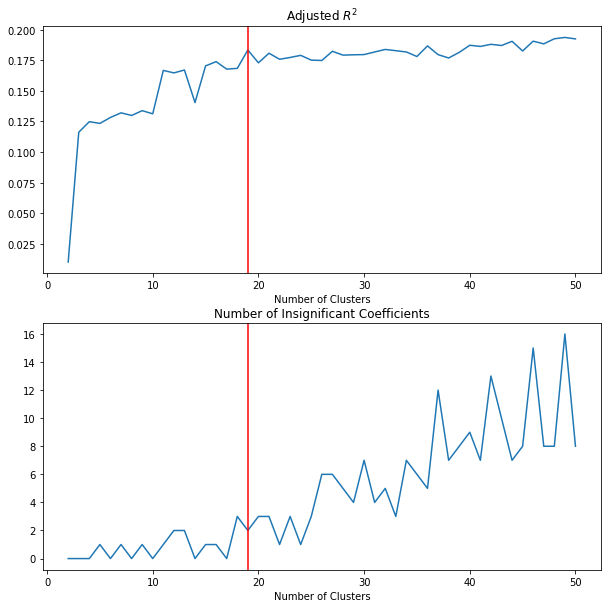

In [55]:
# 繪出各分群下的 調整後R2 與 不顯著係數數量

fig, ax = plt.subplots(figsize=(10,10))

plt.subplot(211)
plt.plot(cluster_n_choose['調整後R2'])
ax.text(19,0.1,'Number of Cluster = 19')
plt.title('Adjusted $R^2$')
plt.axvline(x=19, color='red')
plt.xlabel('Number of Clusters')


plt.subplot(212)
plt.plot(cluster_n_choose['不顯著係數數量'])
plt.axvline(x=19, color='red')
plt.title('Number of Insignificant Coefficients')
plt.xlabel('Number of Clusters')
plt.show()

可以看到分群數量在 19 群之後，調整後R平方增加的速度變緩，而不顯著的係數數量開始迅速上升，因此這裡選擇分 19 群作為 KMean Cluster 的超參數。

## n_cluster = 19

In [60]:
# 將客戶依還款狀態分為 10 群(n_clusters=10)
n_clusters = 19
kmean_model = KMeans(n_clusters=n_clusters, random_state=1).fit(repay_status)
cluster_label = kmean_model.predict(repay_status)

# KMean Cluster Label Data
cluster_label = pd.Series(cluster_label)
cluster_label.index = is_default.index

In [65]:
# 觀察 KMean Cluster 分群人數
cluster_counts = cluster_label.value_counts().sort_index()
cluster_counts.index = ['cluster_'+str(i) for i in cluster_counts.index]
cluster_counts = pd.DataFrame(cluster_counts)
cluster_counts.columns = ['人數']

In [62]:
# 將 KMean Cluster Label 為 dummy variable，用於計算每群違約率
cluster_dummy = pd.get_dummies(cluster_label, prefix='cluster')
cluster_dummy = cluster_dummy.join(is_default)

In [63]:
# Linear Probability Model 
model = sm.OLS(cluster_dummy.is_default, 
               sm.add_constant(cluster_dummy.iloc[:,:-2]))
result = model.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.183     
Dependent Variable: is_default       AIC:                26315.4558
Date:               2018-04-23 21:39 BIC:                26473.3259
No. Observations:   30000            Log-Likelihood:     -13139.   
Df Model:           18               F-statistic:        375.4     
Df Residuals:       29981            Prob (F-statistic): 0.00      
R-squared:          0.184            Scale:              0.14067   
--------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
const           0.2497    0.0130   19.2149  0.0000   0.2242   0.2752
cluster_0       0.3776    0.0182   20.7341  0.0000   0.3419   0.4133
cluster_1      -0.1172    0.0142   -8.2508  0.0000  -0.1450  -0.0894
cluster_2       0.3473    0.0476    7.2922  0.0000   0.2540   0.4407
cluster_3      -0.1436    0.0135  -10.6572  0.0000  -0.1700  -0.1172
cluster_4      -0.1093    0.0149   -7.3527  0.0000  -0.1384  -0.0801
cluster_5       0.4530    0.0168   26.9546  0.0000   0.4201   0.4860
cluster_6       0.1924    0.0172   11.1631  0.0000   0.1586   0.2262
cluster_7       0.3132    0.0190   16.5261  0.0000   0.2761   0.3504
cluster_8      -0.0201    0.0185   -1.0844  0.2782  -0.0563   0.0162
cluster_9       0.1876    0.0203    9.2198  0.0000   0.1477   0.2275
cluster_10      0.0376    0.0171    2.2058  0.0274   0.0042   0.0711
cluster_11     -0.0040    0.0198   -0.2040  0.8384  -0.0428   0.0347
cluster_12      0.5341    0.0455   11.7393  0.0000   0.4449   0.6233
cluster_13      0.3358    0.0196   17.1009  0.0000   0.2973   0.3743
cluster_14     -0.0572    0.0189   -3.0242  0.0025  -0.0943  -0.0201
cluster_15     -0.1353    0.0168   -8.0459  0.0000  -0.1683  -0.1024
cluster_16     -0.0865    0.0191   -4.5369  0.0000  -0.1239  -0.0491
cluster_17      0.1414    0.0216    6.5492  0.0000   0.0991   0.1837
-------------------------------------------------------------------
Omnibus:              4721.421      Durbin-Watson:         2.006   
Prob(Omnibus):        0.000         Jarque-Bera (JB):      7260.280
Skew:                 1.159         Prob(JB):              0.000   
Kurtosis:             3.656         Condition No.:         31      
===================================================================

"""

In [68]:
cluster_ols_params = result.params
cluster_default_rate = (cluster_ols_params[1:]+cluster_ols_params[0]).append(
                        pd.Series(cluster_ols_params[0], 
                        index=['cluster_'+str(len(cluster_ols_params)-1)]))

cluster_default_rate = pd.DataFrame(cluster_default_rate)
cluster_default_rate.columns = ['違約率']
print('n_cluster=19之違約率與該群人數：')
cluster_default_rate.join(cluster_counts)

n_cluster=19之違約率與該群人數：


,違約率,人數
cluster_0,0.627315,864
cluster_1,0.132508,4279
cluster_2,0.597015,67
cluster_3,0.106111,11111
cluster_4,0.140429,2706
cluster_5,0.702746,1238
cluster_6,0.442115,1097
cluster_7,0.562923,739
cluster_8,0.229630,810
cluster_9,0.437282,574


## 設定違約率閥值(Critical Probability)計算模型準確率
假設一給定的違約機率閥值，如果該用戶分群後的違約機率超過該閥值，則設定該用戶會違約，根據此規則計算整體的的準確率。

In [ ]:
default_rate_map = cluster_default_rate
default_rate_map.index = list(range(n_clusters))

cluster_simul = cluster_label.map(default_rate_map.iloc[:,0])
cluster_simul = pd.DataFrame(cluster_simul).join(is_default)
cluster_simul.rename(columns={0:'model_prob'}, inplace=True)

crit_prob = np.arange(0.1,1.0,0.01)

for crit in crit_prob:
    cluster_simul[str(round(crit,2))] = \
            cluster_simul['model_prob'].apply(lambda default_prob:
                                              1 if default_prob>crit else 0)

model_accuracy = [accuracy_score(cluster_simul.is_default, cluster_simul[c])
                  for c in cluster_simul.columns[2:]]
model_accuracy = pd.Series(model_accuracy)
model_accuracy.index = crit_prob

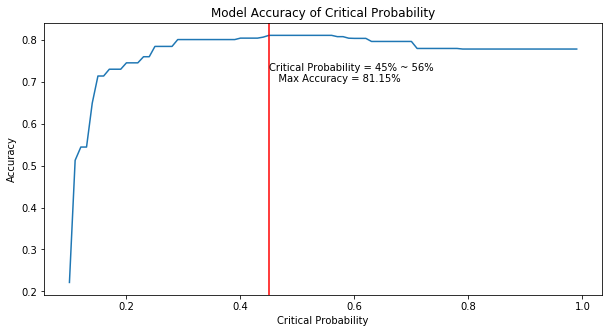

In [192]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(model_accuracy)
ax.text(0.45, 0.7, 'Critical Probability = 45% ~ 56% \n   Max Accuracy = 81.15%')
plt.axvline(x=0.45, color='red')
plt.title('Model Accuracy of Critical Probability')
plt.xlabel('Critical Probability')
plt.ylabel('Accuracy')
plt.show()

在分群19群的情形下，設定違約機率閥值在45%至56%時，此模型的準確率最高，達到81.15%